<a href="https://colab.research.google.com/github/Photonsinnovate/cassava-leaf-disease-classifier/blob/main/cassava_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ../input/pytorch-image-models/timm-0.3.1-py3-none-any.whl

Processing /kaggle/input/pytorch-image-models/timm-0.3.1-py3-none-any.whl


In [ ]:
import numpy as np
import pandas as pd
import os
from fastai.vision.all import *

In [ ]:
set_seed(999)

In [ ]:
dataset_path = Path('../input/cassava-leaf-disease-classification')
os.listdir(dataset_path)

['train_tfrecords',
 'sample_submission.csv',
 'test_tfrecords',
 'label_num_to_disease_map.json',
 'train_images',
 'train.csv',
 'test_images']

In [ ]:
train_df = pd.read_csv(dataset_path/'train.csv')
train_df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [ ]:
train_df['path'] = train_df['image_id'].map(lambda x : dataset_path/'train_images'/x)
train_df = train_df.drop(columns = ['image_id'])
train_df = train_df.sample(frac=1).reset_index(drop=True)
train_df.head()

,label,path
0,3,../input/cassava-leaf-disease-classification/train_images/179052943.jpg
1,3,../input/cassava-leaf-disease-classification/train_images/1393343720.jpg
2,3,../input/cassava-leaf-disease-classification/train_images/3306053383.jpg
3,2,../input/cassava-leaf-disease-classification/train_images/51748275.jpg
4,2,../input/cassava-leaf-disease-classification/train_images/2896377982.jpg


In [ ]:
train_df.shape

(21397, 2)

**Label distribution**

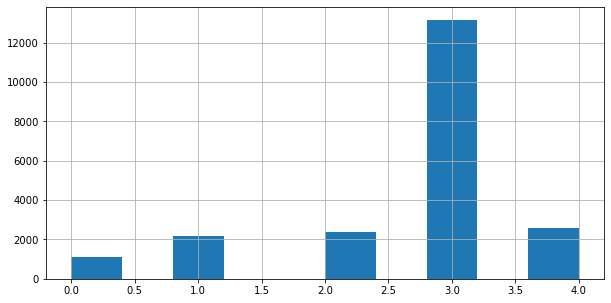

In [ ]:
train_df.label.hist(figsize=(10,5))
plt.show()

In [ ]:
train_df.label.unique()

array([3, 2, 1, 4, 0])

In [ ]:
train_df.label.value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

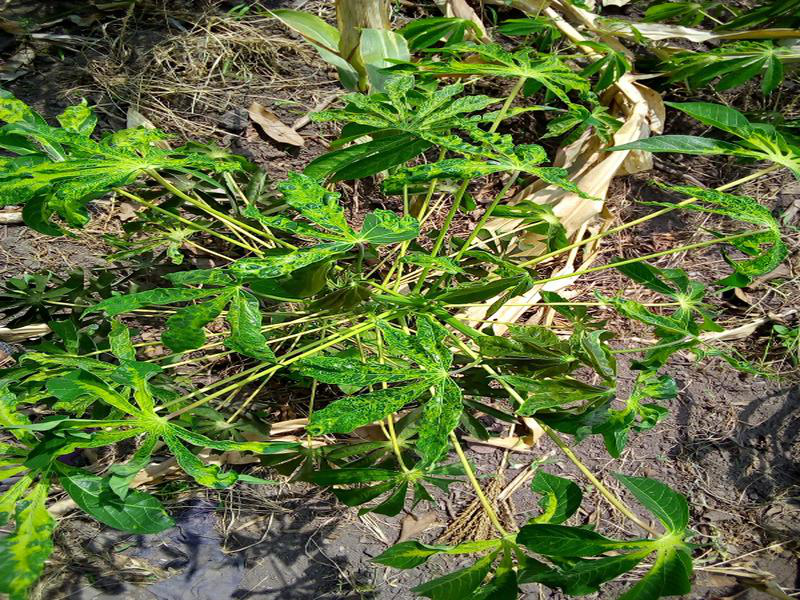

In [ ]:
from PIL import Image

im = Image.open(train_df.path[1])
im

In [ ]:
width, height = im.size
print(width,height) 

800 600


In [ ]:
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
bs=32

In [ ]:
dls = ImageDataLoaders.from_df(train_df,
                               valid_pct= 0.2,
                               seed = 999,
                               label_col = 0,
                               fn_col = 1,
                               bs=bs,
                               item_tfms = item_tfms,
                               batch_tfms = batch_tfms
                              )

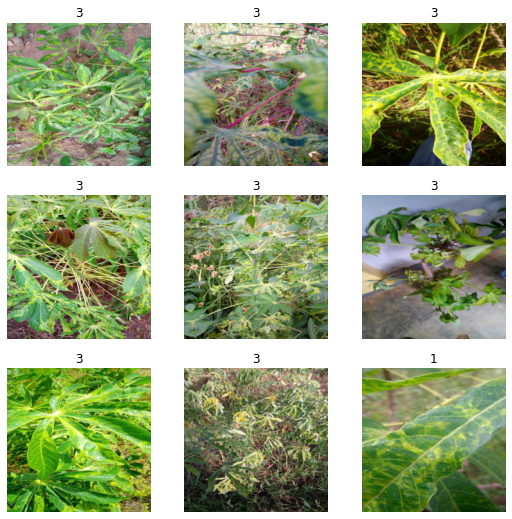

In [ ]:
dls.show_batch()

In [ ]:
# Making pretrained weights work without needing to find the default filename
if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
        os.makedirs('/root/.cache/torch/hub/checkpoints/')
!cp '../input/timmefficientnet/tf_efficientnet_b3_ns-9d44bf68.pth' '/root/.cache/torch/hub/checkpoints/tf_efficientnet_b3_ns-9d44bf68.pth'

In [ ]:
from timm import create_model
from fastai.vision.learner import _update_first_layer

def create_timm_body(arch:str, pretrained=True, cut=None, n_in=3):
    "Creates a body from any model in the `timm` library."
    model = create_model(arch, pretrained=pretrained, num_classes=0, global_pool='')
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")
        
def create_timm_model(arch:str, n_out, cut=None, pretrained=True, n_in=3, init=nn.init.kaiming_normal_, custom_head=None,
                     concat_pool=True, **kwargs):
    "Create custom architecture using `arch`, `n_in` and `n_out` from the `timm` library"
    body = create_timm_body(arch, pretrained, None, n_in)
    if custom_head is None:
        nf = num_features_model(nn.Sequential(*body.children())) * (2 if concat_pool else 1)
        head = create_head(nf, n_out, concat_pool=concat_pool, **kwargs)
    else: head = custom_head
    model = nn.Sequential(body, head)
    if init is not None: apply_init(model[1], init)
    return model

In [ ]:
def timm_learner(dls, arch:str, loss_func=None, pretrained=True, cut=None, splitter=None,
                y_range=None, config=None, n_out=None, normalize=True, **kwargs):
    "Build a convnet style learner from `dls` and `arch` using the `timm` library"
    if config is None: config = {}
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
    model = create_timm_model(arch, n_out, default_split, pretrained, y_range=y_range, **config)
    learn = Learner(dls, model, loss_func=loss_func, splitter=default_split, **kwargs)
    if pretrained: learn.freeze()
    return learn

In [ ]:
learn = timm_learner(dls, 
                    'tf_efficientnet_b3_ns', 
                     opt_func = ranger,
                     loss_func=LabelSmoothingCrossEntropy(),
                     metrics = [accuracy]).to_native_fp16()


SuggestedLRs(lr_min=0.017378008365631102, lr_steep=4.786300905834651e-06)

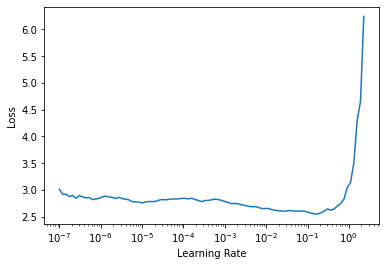

In [ ]:
learn.lr_find()

In [ ]:
learn.freeze()
learn.fit_flat_cos(1, 1e-1, wd=0.5, cbs=[MixUp()])

epoch,train_loss,valid_loss,accuracy,time
0,1.016692,0.821327,0.783127,06:25


In [ ]:
learn.save('stage-1')

Path('models/stage-1.pth')

In [ ]:
learn.load('stage-1')

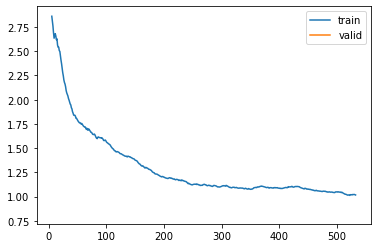

In [ ]:
learn.recorder.plot_loss()

SuggestedLRs(lr_min=0.00043651582673192023, lr_steep=6.309573450380412e-07)

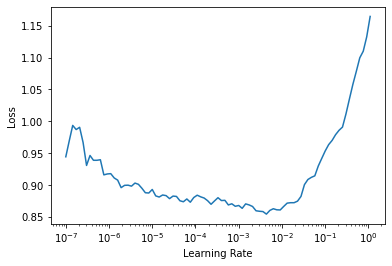

In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.unfreeze()
learn.fit_flat_cos(10,2e-3,pct_start=0,cbs=[MixUp()])

epoch,train_loss,valid_loss,accuracy,time
0,0.979133,0.778590,0.814443,06:21
1,0.932304,0.735171,0.846693,06:14
2,0.916286,0.733474,0.836644,06:21
3,0.891343,0.722486,0.836177,06:16
4,0.867873,0.703953,0.855807,06:15
5,0.878770,0.691401,0.860248,06:10
6,0.868599,0.665434,0.864922,06:08
7,0.828294,0.651824,0.876607,06:21
8,0.823140,0.649306,0.877541,06:23
9,0.816916,0.649259,0.877074,06:28


In [ ]:
learn.to_native_fp32()

In [ ]:
learn.save('stage-2')

Path('models/stage-2.pth')

In [ ]:
learn.export()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

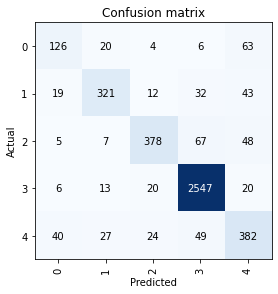

In [ ]:
interp.plot_confusion_matrix()

**Inference**

In [ ]:
sample_df = pd.read_csv(dataset_path/'sample_submission.csv')
sample_df.head()

,image_id,label
0,2216849948.jpg,4


In [ ]:
_sample_df = sample_df.copy()
_sample_df = sample_df['image_id'].map(lambda x : dataset_path/'test_images'/x)
_sample_df = _sample_df.drop(columns=['image_id'])
test_dl = dls.test_dl(_sample_df)

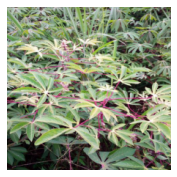

In [ ]:
test_dl.show_batch()

In [ ]:
preds, _ = learn.tta(dl=test_dl, n=8, beta=0)

In [ ]:
preds

tensor([[0.0183, 0.0351, 0.4558, 0.0695, 0.4213]])

In [ ]:
sample_df['label'] = preds.argmax(dim=-1).numpy()

In [ ]:
sample_df.head()

,image_id,label
0,2216849948.jpg,2


In [ ]:
sample_df.to_csv('submission.csv',index=False)